# Predict time from minibatch size
## Using logs from Chainer CIFAR100 sample with various BS on DL server
### Goal: predict one epoch time from batch size using linear regression model

In [14]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess, os
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [10]:
!ls logs/microseries/DL

cifar_log_b1000_l0.150.log cifar_log_b556_l0.150.log
cifar_log_b1001_l0.150.log cifar_log_b557_l0.150.log
cifar_log_b1002_l0.150.log cifar_log_b558_l0.150.log
cifar_log_b1003_l0.150.log cifar_log_b559_l0.150.log
cifar_log_b1004_l0.150.log cifar_log_b560_l0.150.log
cifar_log_b1005_l0.150.log cifar_log_b561_l0.150.log
cifar_log_b1006_l0.150.log cifar_log_b562_l0.150.log
cifar_log_b1007_l0.150.log cifar_log_b563_l0.150.log
cifar_log_b1008_l0.150.log cifar_log_b564_l0.150.log
cifar_log_b1009_l0.150.log cifar_log_b565_l0.150.log
cifar_log_b100_l0.150.log  cifar_log_b566_l0.150.log
cifar_log_b1010_l0.150.log cifar_log_b567_l0.150.log
cifar_log_b1011_l0.150.log cifar_log_b568_l0.150.log
cifar_log_b1012_l0.150.log cifar_log_b569_l0.150.log
cifar_log_b1013_l0.150.log cifar_log_b570_l0.150.log
cifar_log_b1014_l0.150.log cifar_log_b571_l0.150.log
cifar_log_b1015_l0.150.log cifar_log_b572_l0.150.log
cifar_log_b1016_l0.150.log cifar_log_b573_l0.150.log
cifar_log_b1017_l0.150.log cifar_log_b574_l0.1

In [15]:
logs_directory =  "logs/microseries/DL"
filename_pattern=re.compile(r"cifar_.*\.log")

list_command = "ls -1 "+logs_directory
files=[]
proc = subprocess.Popen(list_command.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    line = line.strip(" \n")
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logs_directory,line)))

In [19]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
remove_str="[J"


# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global batch_learn_pattern
    global output_pattern
    global remove_str
    logfile = logfile.strip(" \n")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        time = 0
        epoch = 0
        ind = 0 # DataFrame row numebr (index)
        df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
        for line in lines:
            s = line.strip(' \n')
            s = s.replace(remove_str,"")
            m = batch_learn_pattern.match(s)
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))
            else:
                m2 = output_pattern.match(s)
                if m2:
                    epoch = int(m2.group(1))
                    time = float(m2.group(6))
                    if debug: print batch,learn,epoch,time
                    df.loc[ind] = [batch,learn,epoch,time]
                    ind += 1
                    
    return df

In [20]:
df = pd.DataFrame(data=None,columns=["batch","learn","epoch","time"])
for file in files:
    df1 = fileToDF(file)
    #print df1.head()
    if len(df1) > 0:
        df = pd.concat([df,df1],ignore_index=True)
print df.shape
df.head()

(961, 4)


,batch,learn,epoch,time
0,1000.0,0.15,1.0,24.4252
1,1001.0,0.15,1.0,24.4108
2,1002.0,0.15,1.0,24.4341
3,1003.0,0.15,1.0,24.7236
4,1004.0,0.15,1.0,25.0943


In [21]:
df[df["epoch"]!=1]

,batch,learn,epoch,time


In [22]:
df[df["learn"]!=0.15]

,batch,learn,epoch,time


In [23]:
df.drop(["learn","epoch"],axis=1,inplace=True)

In [29]:
df.head()

,batch,time
0,1000.0,24.4252
1,1001.0,24.4108
2,1002.0,24.4341
3,1003.0,24.7236
4,1004.0,25.0943


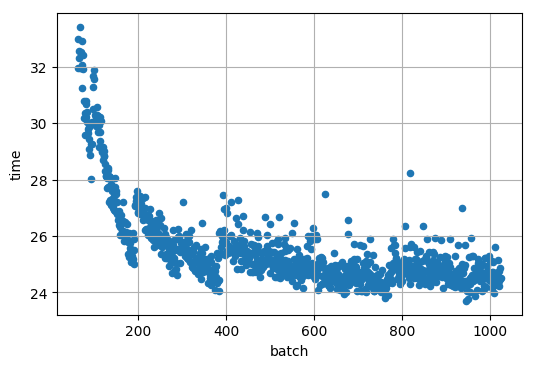

In [33]:
df.plot(kind="scatter",x="batch",y="time",grid=True)

In [46]:
# Create training and test sets.
# Use 200 samples for test.
X_train = df["batch"][:-200].values
X_train = X_train.reshape(-1,1)
print X_train.shape
Y_train = df["time"][:-200].values
X_test = df["batch"][-200:].values
X_test = X_test.reshape(-1,1)
Y_test = df["time"][-200:].values

#X_test

(761, 1)


In [47]:
# Fit Linear regression model
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
H_test = regr.predict(X_test)

In [56]:
mean_squared_error(Y_test, H_test)

1.9760519867497277

In [65]:
print X_test

[[ 819.]
 [  81.]
 [ 820.]
 [ 821.]
 [ 822.]
 [ 823.]
 [ 824.]
 [ 825.]
 [ 826.]
 [ 827.]
 [ 828.]
 [ 829.]
 [  82.]
 [ 830.]
 [ 831.]
 [ 832.]
 [ 833.]
 [ 834.]
 [ 835.]
 [ 836.]
 [ 837.]
 [ 838.]
 [ 839.]
 [  83.]
 [ 840.]
 [ 841.]
 [ 842.]
 [ 843.]
 [ 844.]
 [ 845.]
 [ 846.]
 [ 847.]
 [ 848.]
 [ 849.]
 [  84.]
 [ 850.]
 [ 851.]
 [ 852.]
 [ 853.]
 [ 854.]
 [ 855.]
 [ 856.]
 [ 857.]
 [ 858.]
 [ 859.]
 [  85.]
 [ 860.]
 [ 861.]
 [ 862.]
 [ 863.]
 [ 864.]
 [ 865.]
 [ 866.]
 [ 867.]
 [ 868.]
 [ 869.]
 [  86.]
 [ 870.]
 [ 871.]
 [ 872.]
 [ 873.]
 [ 874.]
 [ 875.]
 [ 876.]
 [ 877.]
 [ 878.]
 [ 879.]
 [  87.]
 [ 880.]
 [ 881.]
 [ 882.]
 [ 883.]
 [ 884.]
 [ 885.]
 [ 886.]
 [ 887.]
 [ 888.]
 [ 889.]
 [  88.]
 [ 890.]
 [ 891.]
 [ 892.]
 [ 893.]
 [ 894.]
 [ 895.]
 [ 896.]
 [ 897.]
 [ 898.]
 [ 899.]
 [  89.]
 [ 900.]
 [ 901.]
 [ 902.]
 [ 903.]
 [ 904.]
 [ 905.]
 [ 906.]
 [ 907.]
 [ 908.]
 [ 909.]
 [  90.]
 [ 910.]
 [ 911.]
 [ 912.]
 [ 913.]
 [ 914.]
 [ 915.]
 [ 916.]
 [ 917.]
 [ 918.]
 [ 919.]
 

In [58]:
H_train = regr.predict(X_train)
mean_squared_error(Y_train, H_train)

1.2927632776057272

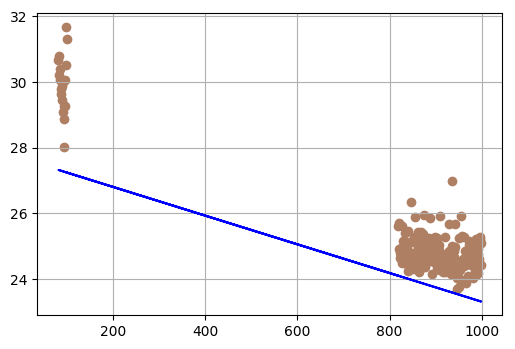

In [79]:
plt.scatter(X_test,Y_test, color="#af7f63")
plt.plot(X_test, H_test, color="blue")
plt.xticks()
plt.yticks()
plt.grid()
plt.show()

In [69]:
df[df["batch"] == 400]["time"].values

array([ 26.9757])

In [70]:
regr.predict([[400.]])

array([ 25.92876271])

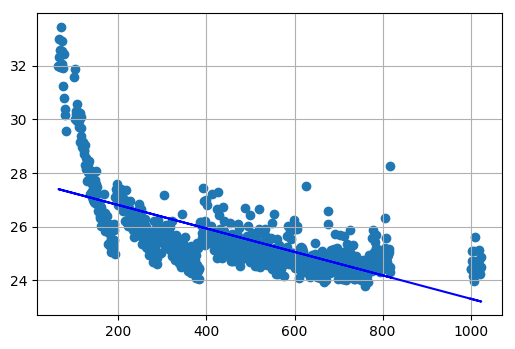

In [64]:
plt.scatter(X_train,Y_train)
plt.plot(X_train, H_train, color="blue")
plt.xticks()
plt.yticks()
plt.grid()
plt.show()